In [1]:
# download movie lens 100k dataset

# !wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
# !unzip ml-100k.zip
import pandas as pd
import numpy as np
ratings = pd.read_csv('ml-100k/u.data', sep='\t', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'])
ratings.drop('timestamp', axis=1, inplace=True)
ratings.head()

,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [2]:
#perform some preprocessing to encode users and movies as integer indices.

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
ratings['user_id'] = le.fit_transform(ratings['user_id'])
ratings['item_id'] = le.fit_transform(ratings['item_id'])

In [3]:
# prompt: Prepare training and validation data

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(ratings, test_size=0.2)
train_data.head()

,user_id,item_id,rating
66243,710,168,5
95308,850,805,4
36522,384,674,5
67589,621,252,3
98589,797,659,3


In [4]:
num_users = len(train_data.user_id.unique())
num_movies = len(train_data.item_id.unique())
min_rating = train_data['rating'].min()
max_rating = train_data['rating'].max()
print(     "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(         num_users, num_movies, min_rating, max_rating     ) )

Number of users: 943, Number of Movies: 1651, Min rating: 1, Max rating: 5


In [5]:
def set_label(data: pd.DataFrame):
    return 1 if data.rating >= 3 else 0

train_data['target'] = train_data.apply(lambda x: 1 if x['rating'] >= 3 else 0, axis=1)
test_data['target'] = test_data.apply(lambda x: 1 if x['rating'] >= 3 else 0, axis=1)

x_train = train_data.drop(columns='target')
y_train = train_data['target']

x_test = test_data.drop(columns='target')
y_test = test_data['target']

In [6]:
class Network:

    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        self.__input_size = input_size
        self.__hidden_size = hidden_size
        self.__output_size = output_size

        self.W1 = np.zeros((self.__hidden_size, self.__input_size))
        self.b1 = np.zeros((self.__hidden_size,1))

        self.W2 = np.zeros((self.__output_size, self.__hidden_size))
        self.b2 = np.zeros((self.__output_size,1))


    def fit(self, x_input: pd.DataFrame, y_input: pd.DataFrame, iteration=100, learning_rate=0.1):

        y_input_one_hot = pd.get_dummies(y_input).to_numpy()
        x_input = x_input.to_numpy()
        m = y_input_one_hot.shape[0]

        loss_list = []
        for _ in range(iteration):

            #first layer
            z1 = np.dot(x_input, self.W1.T).T
            z1 += self.b1

            #second layer
            h1 = self.leaky_relu(z1)
            z2 = np.dot(h1.T, self.W2.T).T
            z2 += self.b2

            y_pred = self.softmax(z2)

            loss = self.compute_loss(y_real=y_input, y_predicted=y_pred)
            sum_loss = np.sum(loss)
            loss_list.append(sum_loss)

            #Derivatives
            dz2 = z2 - y_input_one_hot.T
            dw2 = (1/m) * np.dot(dz2, h1.T)
            db2 = (1/m) * np.sum(dz2)


            dh1 = np.matmul(self.W2.T, dz2)
            dz1 = dh1 * np.vectorize(self.leaky_relu_derivative)(z1)
            dw1 = (1/m) * np.dot(dz1, x_input)
            db1 = (1./m) * np.sum(dz1)


            # Gradient Descent
            self.W1 = self.W1 - learning_rate * dw1
            self.W2 = self.W2 - learning_rate * dw2

            self.b1 = self.b1 - learning_rate * db1
            self.b2 = self.b2 - learning_rate * db2

        embeding = y_pred
        return embeding, loss_list


    def predict(self, x_input: pd.DataFrame):
        z1 = np.dot(x_input, self.W1.T).T
        z1 += self.b1

        #second layer
        a1 = np.vectorize(self.leaky_relu)(z1)
        z2 = np.dot(a1.T, self.W2.T).T
        z2 += self.b2
        return np.argmax(self.softmax(z2), axis=0)

    @classmethod
    def leaky_relu(cls, x, alpha=0.01):
        return np.maximum(x*alpha, alpha)

    @classmethod
    def leaky_relu_derivative(cls, x, alpha=0.01):
        return 1.0 if x >= 0.0 else alpha

    @classmethod
    def softmax(cls, x):
        return np.exp(x)/np.sum(np.exp(x))

    @classmethod
    def compute_loss(cls, y_real, y_predicted: pd.DataFrame):
        y_real_one_hot = pd.get_dummies(y_real)

        loss_sum = np.sum(np.multiply(y_real_one_hot.T, np.log(y_predicted)))
        m = y_real_one_hot.shape[0]
        loss = -(1/m) * loss_sum
        return loss

In [7]:
nn = Network(input_size=3, hidden_size=64, output_size=2)
embeding, loss_list = nn.fit(x_train, y_train, iteration=50, learning_rate=0.05)

embeding

array([[6.24881212e-06, 6.24881212e-06, 6.24881212e-06, ...,
        6.24881212e-06, 6.24881212e-06, 6.24881212e-06],
       [6.25118788e-06, 6.25118788e-06, 6.25118788e-06, ...,
        6.25118788e-06, 6.25118788e-06, 6.25118788e-06]])

In [8]:
from sklearn.metrics import accuracy_score, classification_report
y_pred = nn.predict(x_test)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3434
           1       0.83      1.00      0.91     16566

    accuracy                           0.83     20000
   macro avg       0.41      0.50      0.45     20000
weighted avg       0.69      0.83      0.75     20000



C:\Users\acer\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\acer\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\acer\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
y_pred_train = nn.predict(x_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     14046
           1       0.82      1.00      0.90     65954

    accuracy                           0.82     80000
   macro avg       0.41      0.50      0.45     80000
weighted avg       0.68      0.82      0.75     80000



C:\Users\acer\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\acer\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\acer\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

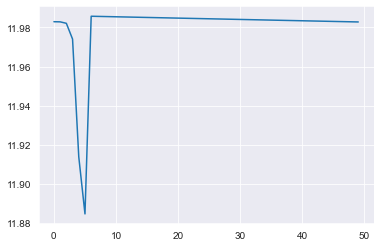

In [9]:
import seaborn as sns
iteration = list(range(len(loss_list)))
sns.lineplot(x=iteration, y=loss_list)